# MILP/MINLP Formulation of Active Fund Manager assessment

The following is a Jupyter notebook implementation of S Balan's work 'MILP and MINLP Formulation for Active fund performance analysis'

In [1]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options
import numpy as np
import sys
import gamspy as gp
import math
import matplotlib.pyplot as plt
import pickle
import yfinance


## Loading price data

The following code loads and prepares a price array from a list of Russell 1000 stocks. Not all stocks will successfully load as the names in the index are dynamic and changes all the time. Stocks that failed to fetch price data are removed. The average weekly price is considered. We add a month 0, making the price array 13 months to consider the fact the model needs a month 0 where it basically initiates the cash position in december before it starts executing buy orders in January

In [10]:
# Load the data
price_df = pd.read_csv('russell_1000_stock_prices_2024.csv')

# Extract the tickers (first column) as a numpy array
tickers = price_df.iloc[:, 0].to_numpy()

# Set the first column (tickers) as the index
price_df.set_index(price_df.columns[0], inplace=True)

# Convert column names to datetime, stripping timezone information
price_df.columns = pd.to_datetime(price_df.columns.str.replace(r'-\d{2}:\d{2}$', '', regex=True))

# Transpose the DataFrame to make dates the index
price_df = price_df.T

# Resample the data to monthly frequency, taking the mean of each month
monthly_price_df = price_df.resample('M').mean()

# Transpose back to get stocks as rows and months as columns
monthly_price_df = monthly_price_df.T

# Convert the monthly price DataFrame to a numpy array
monthly_price_array = monthly_price_df.to_numpy()

# Identify rows with NaN or zero values
rows_with_nan_or_zero = np.isnan(monthly_price_array).any(axis=1) | (monthly_price_array == 0).any(axis=1)

# Filter out rows with NaN or zero values
monthly_price_array = monthly_price_array[~rows_with_nan_or_zero]
tickers = tickers[~rows_with_nan_or_zero]

# Final output
price_array = monthly_price_array


# Add a new column (Month 0) to price_array, equal to the prices in Month 1
month_0_prices = price_array[:, 0][:, np.newaxis]  # Extract Month 1 prices and reshape to column vector
price_array_with_month_0 = np.hstack((month_0_prices, price_array))  # Concatenate Month 0 with the original array

# Update price_array
price_array = price_array_with_month_0

C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_2360\2665400743.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price_df = price_df.resample('M').mean()


In [11]:
price_array.shape

(980, 13)

Visualising the individual movements in the index yields the following chart

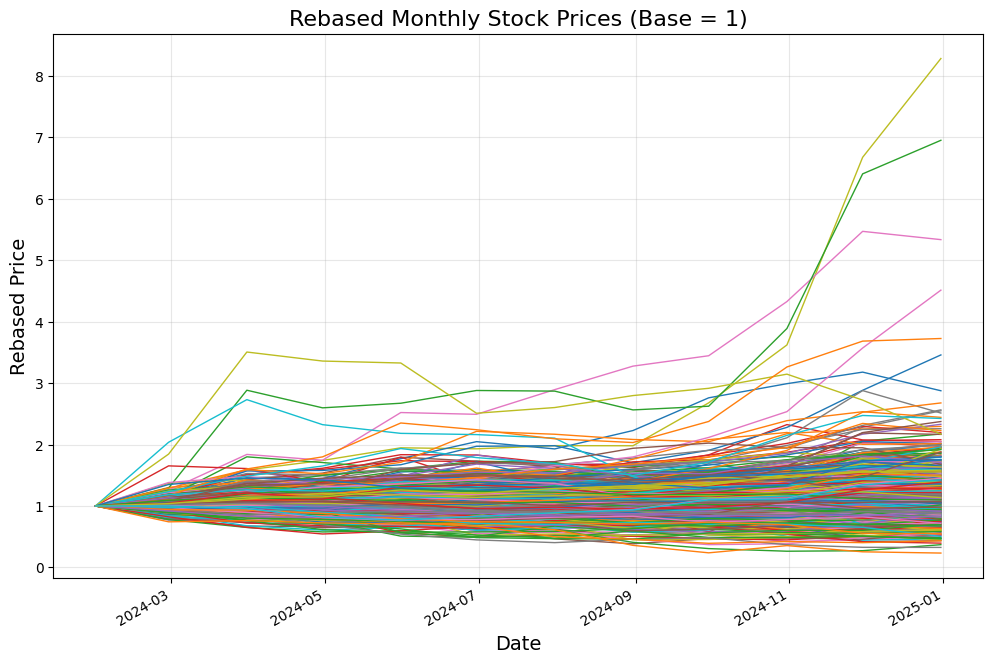

In [12]:


# Rebase all price series to 1 for visualization
rebased_price_array = monthly_price_array / monthly_price_array[:, 0][:, np.newaxis]

# Create a time index for the x-axis (assuming the columns are monthly dates)
time_index = monthly_price_df.columns

# Plot all rebased price series
plt.figure(figsize=(12, 8))
for i in range(rebased_price_array.shape[0]):
    plt.plot(time_index, rebased_price_array[i], linewidth=1)

# Add labels and title
plt.title('Rebased Monthly Stock Prices (Base = 1)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rebased Price', fontsize=14)
plt.grid(alpha=0.3)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

In [13]:
# Calculate the percentage change for each stock
percentage_changes = ((monthly_price_array[:, -1] - monthly_price_array[:, 0]) / monthly_price_array[:, 0] * 100)

# Create a DataFrame to associate tickers with their percentage changes
movement_df = pd.DataFrame({
    'Ticker': tickers,
    'Percentage Change': percentage_changes
})

# Sort by percentage change to get top and bottom movers
top_10_movers = movement_df.nlargest(10, 'Percentage Change')
bottom_10_movers = movement_df.nsmallest(10, 'Percentage Change')

# Display the results
print("Top 10 Positive Movers:")
print(top_10_movers)
print("\nBottom 10 Movers:")
print(bottom_10_movers)

Top 10 Positive Movers:
    Ticker  Percentage Change
68     APP         728.128423
602   MSTR         595.041036
236   CVNA         433.410736
706   PLTR         351.201891
921    VST         272.522154
430   HOOD         245.787284
150   CAVA         187.509610
891     UI         167.671418
637   NTRA         156.373108
87    AXON         154.923225

Bottom 10 Movers:
    Ticker  Percentage Change
951   WOLF         -76.609131
877    TXG         -67.421246
622    NFE         -62.970349
593   MRNA         -60.477337
931    WBA         -56.706526
215   CPRI         -56.457465
458   INTC         -55.409645
199   CNXC         -53.620912
522    LEG         -53.540018
792   SIRI         -52.721546


## Model

The model designed here is a Mixed-Integer Non-Linear Programming model. What this does it explicitly defines a number of equations that govern the flow of cash between specific assets and the fund's cash position. The goal of the model is to state which exact direction and magnitude of cash flow will generate either the maximum, minimum, or specified return at the end of the time-period. Similar to a route-finding or path-tracing algorithm. 

## Parameters

These parameters present the structure of the fund's mandate. It sets the rules on how the state of the portfolio must be at all times. 

In [14]:
# Portfolio Configuration Parameters

# Maximum exposure allowed for any single stock as a fraction of the portfolio's Net Asset Value (NAV) at any time
max_exposure = 0.05

# Maximum fraction of NAV that can be allocated to buying a single stock at any time
buy_exposure = 0.03

# Cap on the maximum return (as a multiplier) that any single stock can contribute to the portfolio before the manager exits the position
max_return = 1.50

# Portfolio turnover rate (100% = 1), representing the rate at which assets are bought and sold within the portfolio. This is useful as it puts a restrictions 
# on trading volumes
PT = 2.80

# Minimum cash position in percentage to maintain as a fraction of NAV, ensuring liquidity
cash_min = 0.01

# Maximum cash position allowed as a fraction of NAV, limiting idle cash
cash_max = 0.05

# Multiplier applied to account for bid/ask spread + transaction when buying a stock (e.g., 1.01 represents a 1% fee)
bfee = 1.01

# Multiplier applied to account for bid/ask spread + transaction when selling a stock (e.g., 0.99 represents a 1% fee)
sfee = 0.99

# Target return multiplier for the portfolio (e.g., 1.40 represents a 40% target return) at the end of the simulation period
expected_return = 1.40

# Initial cash balance available for portfolio construction and trading. This value doesn't really matter since it can be rebased up or down linearly.
init_cash = 1000000

# A small constant used for numerical stability in calculations (e.g., to avoid division by zero) - 
eps = 0.0000001

# A large constant used in the big-M method for linear programming constraints
M = 100000000

## Defining the model and its equations

### Sets in the MILP Model

1. **`time_index = 12`**  
   - Represents the total number of time periods in the model (e.g., 12 months).

2. **`stocks`**  
   - A set containing all the stock tickers (`tickers`) in the portfolio.  
   - Used to define decision variables and constraints for each stock.

3. **`time`**  
   - A set representing all time periods, from `0` to `time_index - 1` (e.g., 0 to 12 for 13 months).  
   - Used to define time-dependent variables and constraints.

4. **`subtime`**  
   - A subset of `time` that excludes the first period (e.g., periods `1` to `12`).  
   - This is the subset of time where trades can actually occur. 

5. **`subtime2`**  
   - A subset of `time` that excludes the first two periods (e.g., periods `2` to `12`).  
   - This is the subset of time used to calculate portfolio turnover. The problem with including Month 1 (January) into the portfolio turnover equation is that it will artificially boost the turnover as the fund starts with a full cash position. So including that month will not make sense.

In [18]:
# Define the model container
m = Container()

# Sets
time_index = 13
stocks = Set(container=m, name="stocks", records=tickers)  # Set of stocks
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))  # Time periods
subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))  # Excludes first period
subtime2 = Set(container=m, domain=time, records=np.arange(2, time_index, 1))  # Excludes first two periods

# Data: Stock prices indexed by stocks and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=price_array,
)


### Variables in the MILP Model

1. **`C`**  
   - Represents the **cash balance** at each time period.  
   - Ensures liquidity is tracked over time.

2. **`V`**  
   - Represents the **Net Asset Value (NAV)** of the portfolio at each time period.  
   - Tracks the total value of the portfolio (cash + stock holdings).

3. **`x`**  
   - Represents the **holdings** of each stock at each time period.  
   - Tracks the quantity of each stock held in the portfolio.  
   - Initial holdings are fixed to 0 (`x.fx[stocks, '0'] = 0`).

4. **`b`**  
   - Represents the **quantity of stocks bought** at each time period.  
   - Tracks purchases of each stock.  
   - Initial buying is fixed to 0 (`b.fx[stocks, '0'] = 0`).

5. **`bp`**  
   - Represents the **value of stocks bought** at each time period.  
   - Semi-continuous variable with lower and upper bounds on how much of one stock can be bought at any time (`bp.lo = 5000`, `bp.up = 100000`).

6. **`sp`**  
   - Represents the **value of stocks sold** at each time period.  
   - Tracks the proceeds from selling stocks.

7. **`s`**  
   - Represents the **quantity of stocks sold** at each time period.  
   - Tracks sales of each stock.

8. **`Z`**  
   - Represents the **objective variable** to be optimized (e.g., maximizing profit or minimizing risk).

9. **`Sr`**  
   - Represents the **total sales** of each stock over all time periods.  
   - Aggregates sales for each stock.

10. **`Br`**  
    - Represents the **total purchases** of each stock over all time periods.  
    - Aggregates purchases for each stock.

11. **`gamma_s`**  
    - A **binary indicator** for whether a stock is sold at a given time period.  
    - Used to enforce sell-related constraints.

12. **`gamma_b`**  
    - A **binary indicator** for whether a stock is bought at a given time period.  
    - Used to enforce buy-related constraints.

13. **`profit`**  
    - Represents the **profit** (or loss) for each stock over the investment horizon.  
    - Tracks the net gain/loss per stock.

14. **`omega`**  
    - A **binary variable** indicating whether a stock is a **winner** (e.g., meets a certain return threshold).  
    - Used for performance-based constraints.

15. **`omega_trades`**  
    - A **binary variable** indicating whether a stock was **traded** (bought or sold) at any point.  
    - Used to track trading activity.

In [19]:


# Variables
C = Variable(container=m, name="C", domain=time, type="Positive")  # Cash balance
V = Variable(container=m, name="V", domain=time, type="Positive")  # Net Asset Value
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")  # Holdings
x.fx[stocks, '0'] = 0  # No initial holdings

b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")  # Stocks bought
bp = Variable(container=m, name="bp", domain=[stocks, time], type="SemiCont")  # Stocks bought value
sp = Variable(container=m, name="sp", domain=[stocks, time], type="Positive")  # Stocks sold value
b.fx[stocks, '0'] = 0  # No initial buying
bp.lo[stocks, time] = 5000
bp.up[stocks, time] = 100000

s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")  # Stocks sold
Z = Variable(container=m, name="Z", type="free")  # Objective variable
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")  # Total sales
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")  # Total purchases

gamma_s = Variable(container=m, name="gs", domain=[stocks, time], type="Binary")  # Sell indicator
gamma_b = Variable(container=m, name="gb", domain=[stocks, time], type="Binary")  # Buy indicator

profit = Variable(container=m, name="profit", domain=[stocks], type="Free")  # Profit per stock
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")  # Binary variable if stock is a winner
omega_trades = Variable(container=m, name="omega_trades", domain=[stocks], type="Binary")  # Binary variable if stock was traded


## Model equations

### Ensuring a stock is only sold or bought at any one time. 

The underlying model has no intrinsic understanding of what it's doing, so we need to force it to understand that at any one time for any stock, you can only have a net long or short position

It can be written as:

$$
\gamma_s^{i,t} + \gamma_b^{i,t} \leq 1 \quad \forall i \in \text{stocks}, \, t \in \text{time}
$$

Where:
- $\gamma_s^{i,t}$ is the binary sell indicator for stock $ i $ at time $ t $.
- $\gamma_b^{i,t}$ is the binary buy indicator for stock $ i $ at time $ t $.


In [20]:
# Equations
buy_or_sell = Equation(
    m,
    name="buy_or_sell",
    domain=[stocks, time],
    description="Ensures a stock is either bought or sold at time t, but not both"
)
buy_or_sell[stocks, time] = (1 >= gamma_s[stocks, time] + gamma_b[stocks, time])

### Setting the binary variables such that it turns on/off depending on if the associated stock was ever bought

1. **First Constraint**:
   $$
   \sum_{t \in \text{time}} \text{bp}^{i,t} \leq M \cdot \omega_{\text{trades}}^i \quad \forall i \in \text{stocks}
   $$

2. **Second Constraint**:
   $$
   \sum_{t \in \text{time}} \text{bp}^{i,t} \geq 10 \cdot \omega_{\text{trades}}^i \quad \forall i \in \text{stocks}
   $$


Symbol Explanations
- $\text{bp}^{i,t}$: Value of stock $i$ bought at time $t$.
- $\omega_{\text{trades}}^i$: Binary variable indicating if stock $i$ was traded ever through the life of the fund.
- $M$: A large constant (big-M) used for linearization.
- $10$: A threshold value to ensure $\omega_{\text{trades}}^i$ is set correctly. If more than 10 dollars of that stock is bought, then we consider it bought. We could put 0.0001 as the limit, but 10 works a bit better.
- $\text{time}$: Set of time periods.
- $\text{stocks}$: Set of stocks.

In [21]:
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Sets omega_trades to 1 if stock was traded (Br[stocks] > 0)"
)
omega_trades_determination[stocks] = (
    Sum(time, bp[stocks, time]) <= M * omega_trades[stocks]
)

omega_trades_determination2 = Equation(
    m,
    name="omega_trades_determination2",
    domain=[stocks],
    description="Ensures omega_trades is 1 if stock was traded (Br[stocks] > 0)"
)
omega_trades_determination2[stocks] = (
    Sum(time, bp[stocks, time]) >= 10 * omega_trades[stocks]
)

### Setting the binary variables such that it turns on/off depending on if the associated stock was bought/sold at a specific time

1. **Buy Limit Constraint**:
   $$
   b^{i,t} \leq M \cdot \gamma_b^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$

2. **Sell Limit Constraint**:
   $$
   s^{i,t} \leq M \cdot \gamma_s^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$



**Symbol Explanations**
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $s^{i,t}$: Quantity of stock $i$ sold at time $t$.
- $\gamma_b^{i,t}$: Binary buy indicator for stock $i$ at time $t$.
- $\gamma_s^{i,t}$: Binary sell indicator for stock $i$ at time $t$.
- $M$: A large constant (big-M) used for linearization.
- $\text{stocks}$: Set of stocks.
- $\text{time}$: Set of time periods.

In [22]:

buy_limit = Equation(
    m,
    name="buy_limit",
    domain=[stocks, time],
    description="Activates gamma_b if stock is bought at time t"
)
buy_limit[stocks, time] = b[stocks, time] <= M * gamma_b[stocks, time]

sell_limit = Equation(
    m,
    name="sell_limit",
    domain=[stocks, time],
    description="Activates gamma_s if stock is sold at time t"
)
sell_limit[stocks, time] = s[stocks, time] <= M * gamma_s[stocks, time]

## Determining the position value of each stock at each time

1. **Stocks Bought Value**:
   $$
   \text{bp}^{i,t} = b^{i,t} \cdot \text{prices}^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$

2. **Stocks Sold Value**:
   $$
   \text{sp}^{i,t} = s^{i,t} \cdot \text{prices}^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$

**Symbol Explanations**
- $\text{bp}^{i,t}$: Value of stock $i$ bought at time $t$.
- $\text{sp}^{i,t}$: Value of stock $i$ sold at time $t$.
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $s^{i,t}$: Quantity of stock $i$ sold at time $t$.
- $\text{prices}^{i,t}$: Price of stock $i$ at time $t$.
- $\text{stocks}$: Set of stocks.
- $\text{time}$: Set of time periods.

In [23]:
stocks_bought_value = Equation(
    m,
    name="stocks_bought_value",
    domain=[stocks, time],
    description="Calculates the value of stocks bought at time t"
)
stocks_bought_value[stocks, time] = (bp[stocks, time] == b[stocks, time] * prices[stocks, time])

stocks_sold_value = Equation(
    m,
    name="stocks_sold_value",
    domain=[stocks, time],
    description="Calculates the value of stocks sold at time t"
)
stocks_sold_value[stocks, time] = (sp[stocks, time] == s[stocks, time] * prices[stocks, time])


### Determining whether a particular stock was an overall winning/losing trade
1. **Winner Determination**:
   $$
   \text{profit}^i \geq 10 \cdot \omega^i - M \cdot (1 - \omega^i) \quad \forall i \in \text{stocks}
   $$

2. **Loser Determination**:
   $$
   \text{profit}^i \leq M \cdot \omega^i \quad \forall i \in \text{stocks}
   $$

**Symbol Explanations**
- $\text{profit}^i$: Profit (or loss) of stock $i$.
- $\omega^i$: Binary variable indicating if stock $i$ is a winner ($\omega^i = 1$) or a loser ($\omega^i = 0$).
- $M$: A large constant (big-M) used for linearization.
- $10$: A threshold value to ensure $\omega^i$ is set correctly.
- $\text{stocks}$: Set of stocks.

In [24]:
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Sets omega to 1 if stock was a winner (profit > 0)"
)
winner_determination[stocks] = (
    profit[stocks] >= 10 * omega[stocks] - M * (1 - omega[stocks])
)

# Loser determination
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Sets omega to 0 if stock was a loser (profit <= 0)"
)
loser_determination[stocks] = (
    profit[stocks] <= M * omega[stocks]
)


### Other equations on total sale value, total purchase value, Pnl


1. **Total Sales**:
   $$
   \text{Sr}^i = \sum_{t \in \text{time}} \text{prices}^{i,t} \cdot s^{i,t} \quad \forall i \in \text{stocks}
   $$

2. **Total Purchases**:
   $$
   \text{Br}^i = \sum_{t \in \text{time}} \text{prices}^{i,t} \cdot b^{i,t} \quad \forall i \in \text{stocks}
   $$

3. **Profit and Loss (PnL)**:
   $$
   \text{profit}^i = \left( \text{Sr}^i + x^{i,T} \cdot \text{prices}^{i,T} \right) - \text{Br}^i \quad \forall i \in \text{stocks}
   $$

 **Symbol Explanations**
- $\text{Sr}^i$: Total revenue from selling stock $i$.
- $\text{Br}^i$: Total cost from buying stock $i$.
- $\text{profit}^i$: Profit (or loss) of stock $i$.
- $\text{prices}^{i,t}$: Price of stock $i$ at time $t$.
- $s^{i,t}$: Quantity of stock $i$ sold at time $t$.
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $x^{i,T}$: Holdings of stock $i$ at the final time period $T$.
- $\text{time}$: Set of time periods.
- $\text{stocks}$: Set of stocks.
- $T$: Final time period ($T = \text{time\_index} - 1$).

In [25]:
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates total revenue from selling stock"
)
total_sales[stocks] = (Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time]))

total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates total cost from buying stock"
)
total_purchases[stocks] = (Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time]))

pnl = Equation(
    m,
    name="pnl",
    domain=[stocks],
    description="Calculates profit for each stock"
)
pnl[stocks] = (
    profit[stocks] == 
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) - Br[stocks]
)

### Portfolio turnover constraints

**Portfolio Turnover**:
$$
\text{PT} \cdot \left( V^{Feb} + V^{T} \right) \leq 2 \cdot \sum_{i \in \text{stocks}} \sum_{t \in \text{subtime2}} b^{i,t} \cdot \text{prices}^{i,t}
$$

**Symbol Explanations**
- $\text{PT}$: Portfolio turnover rate.
- $V^{Feb}$: Net Asset Value (NAV) at February (Not January as the majority cash is used to take positions immediately in the simulation).
- $V^{T}$: Net Asset Value (NAV) at the final time period $T$.
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $\text{prices}^{i,t}$: Price of stock $i$ at time $t$.
- $\text{stocks}$: Set of stocks.
- $\text{subtime2}$: Subset of time periods excluding the first two periods.
- $T$: Final time period ($T = \text{time\_index} - 1$).

In [26]:
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="Calculates portfolio turnover"
)
portfolio_turnover[...] = (
    PT * (V["1"] + V[str(time_index-1)]) <= 
    Sum(stocks, Sum(subtime2, b[stocks, subtime2] * prices[stocks, subtime2])) * 2
)


### Setting the constraint for max return of each stock

$$
\text{Sr}^i + x^{i,T} \cdot \text{prices}^{i,T} \leq \text{Br}^i \cdot \text{max\_return} \quad \forall i \in \text{stocks}
$$

**Symbol Explanations**
- $\text{Sr}^i$: Total revenue from selling stock $i$.
- $x^{i,T}$: Holdings of stock $i$ at the final time period $T$.
- $\text{prices}^{i,T}$: Price of stock $i$ at the final time period $T$.
- $\text{Br}^i$: Total cost from buying stock $i$.
- $\text{max\_return}$: Cap on maximum return per stock (e.g., 1.5 for 150% return).
- $\text{stocks}$: Set of stocks.
- $T$: Final time period ($T = \text{time\_index} - 1$).

In [27]:

max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="Caps maximum returns per stock"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) <= 
    Br[stocks] * max_return
)

### Setting the core constraints that simulate the dynamic holdings of the fund

1. **Holdings Balance Over Time**:
   $$
   x^{i,t} = x^{i,t-1} + b^{i,t} - s^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{subtime}
   $$

2. **Initial Holdings Balance**:
   $$
   x^{i,0} = 0 \quad \forall i \in \text{stocks}
   $$

**Symbol Explanations**
- $x^{i,t}$: Holdings of stock $i$ at time $t$.
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $s^{i,t}$: Quantity of stock $i$ sold at time $t$.
- $\text{subtime}$: Subset of time periods excluding the first period.
- $\text{stocks}$: Set of stocks.

In [28]:


holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Tracks holdings balance over time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
)

holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial stock holdings"
)
holdings_balance_initial[stocks] = (x[stocks, "0"] == 0)


### Setting constraints that govern the cash positions


1. **Minimum Cash Balance**:
   $$
   C^t \geq \text{cash\_min} \cdot V^t \quad \forall t \in \text{time}
   $$

2. **Maximum Cash Balance**:
   $$
   C^t \leq \text{cash\_max} \cdot V^t \quad \forall t \in \text{subtime}
   $$


   
3. **Cash Balance Over Time**:
   $$
   C^t = C^{t-1} - \text{bfee} \cdot \sum_{i \in \text{stocks}} \text{bp}^{i,t} + \text{sfee} \cdot \sum_{i \in \text{stocks}} \text{sp}^{i,t} \quad \forall t \in \text{time}
   $$

4. **Initial Cash Balance**:
   $$
   C^0 = \text{init\_cash}
   $$

   
 **Symbol Explanations**
- $C^t$: Cash balance at time $t$.
- $V^t$: Net Asset Value (NAV) at time $t$.
- $\text{cash\_min}$: Minimum cash balance as a fraction of NAV.
- $\text{cash\_max}$: Maximum cash balance as a fraction of NAV.
- $\text{time}$: Set of time periods.
- $\text{subtime}$: Subset of time periods excluding the first period.
-  $\text{bp}^{i,t}$: Value of stock $i$ bought at time $t$.
- $\text{sp}^{i,t}$: Value of stock $i$ sold at time $t$.
- $\text{bfee}$: Buy fee multiplier (e.g., 1.01 for a 1% fee).
- $\text{sfee}$: Sell fee multiplier (e.g., 0.99 for a 1% fee).
- $\text{init\_cash}$: Initial cash balance.
- $\text{stocks}$: Set of stocks.


In [29]:
cash_constraint1 = Equation(
    m,
    name="cash_constraint1",
    domain=[time],
    description="Ensures minimum cash balance"
)
cash_constraint1[time] = (
    C[time] >= cash_min * V[time]
)




cash_constraint2 = Equation(
    m,
    name="cash_constraint2",
    domain=[subtime],
    description="Ensures maximum cash balance"
)
cash_constraint2[subtime] = (
    C[subtime] <= cash_max * V[subtime]
)


cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Tracks cash balance at each time period"
)
cash_balance[time] = (
    C[time] == C[time - 1] - 
    Sum(stocks, bfee * bp[stocks, time]) + 
    Sum(stocks, sfee * sp[stocks, time])
)

cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance"
)
cash_balance_initial[...] = (C["0"] == init_cash)


### Equations governing NAV, risk limits

1. **Net Asset Value (NAV)**:
   $$
   V^t = C^t + \sum_{i \in \text{stocks}} \text{prices}^{i,t} \cdot x^{i,t} \quad \forall t \in \text{time}
   $$

2. **Risk Constraint (Position Exposure)**:
   $$
   \text{max\_exposure} \cdot V^t \geq \text{prices}^{i,t} \cdot x^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$

3. **Buy Risk Constraint (Buying Exposure)**:
   $$
   \text{buy\_exposure} \cdot V^t \geq \text{prices}^{i,t} \cdot b^{i,t} \quad \forall i \in \text{stocks}, \, t \in \text{time}
   $$

**Symbol Explanations**
- $V^t$: Net Asset Value (NAV) at time $t$.
- $C^t$: Cash balance at time $t$.
- $\text{prices}^{i,t}$: Price of stock $i$ at time $t$.
- $x^{i,t}$: Holdings of stock $i$ at time $t$.
- $b^{i,t}$: Quantity of stock $i$ bought at time $t$.
- $\text{max\_exposure}$: Maximum exposure per stock as a fraction of NAV.
- $\text{buy\_exposure}$: Maximum buying exposure per stock as a fraction of NAV.
- $\text{stocks}$: Set of stocks.
- $\text{time}$: Set of time periods.

In [30]:
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculates Net Asset Value"
)
nav[time] = (V[time] == C[time] + Sum(stocks, prices[stocks, time] * x[stocks, time]))

risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks, time],
    description="Limits position exposure"
)
risk_constraint[stocks, time] = (max_exposure * V[time] >= prices[stocks, time] * x[stocks, time])

buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks, time],
    description="Limits buying exposure"
)
buy_risk_constraint[stocks, time] = (buy_exposure * V[time] >= prices[stocks, time] * b[stocks, time])

### Final equations and objective functions


**Variables and Equations**

1. **`Z_plus` and `Z_minus`**:
   - **`Z_plus`**: Represents the **number of winning trades** (stocks with positive profit, i.e., $\omega^i = 1$).
   - **`Z_minus`**: Represents the **number of all trades** (stocks that were traded, i.e., $\omega_{\text{trades}}^i = 1$).
   - These variables are used to track and optimize the performance of the portfolio in terms of winning trades and overall trading activity.

2. **`constraint_deviation`**:
   - This equation ensures that `Z_plus` equals the **total number of winning trades**:
     $$
     Z_+ = \sum_{i \in \text{stocks}} \omega^i
     $$
   - Here, $\omega^i$ is a binary variable indicating whether stock $i$ is a winner ($\omega^i = 1$ if profit > 0).

3. **`constraint_deviation2`**:
   - This equation ensures that `Z_minus` equals the **total number of trades**:
     $$
     Z_- = \sum_{i \in \text{stocks}} \omega_{\text{trades}}^i
     $$
   - Here, $\omega_{\text{trades}}^i$ is a binary variable indicating whether stock $i$ was traded ($\omega_{\text{trades}}^i = 1$ if the stock was bought or sold).

4. **`portfolio_returns`**:
   - This equation ensures that the **final portfolio value** meets the **expected return**:
     $$
     V^T = \text{expected\_return} \cdot \text{init\_cash}
     $$
   - Here:
     - $V^T$ is the Net Asset Value (NAV) at the final time period $T$).
     - $\text{expected\_return}$ is the target return multiplier (e.g., 1.4 for a 40% return).
     - $\text{init\_cash}$ is the initial cash balance.

5. **`obj_function`**:
   - This equation defines the **objective function** to be optimized:
     $$
     Z = Z_+ - Z_-
     $$
   - Here:
     - \(Z_+\) represents the number of winning trades.
     - \(Z_-\) represents the number of all trades.
     - The objective is to **maximize $Z$**, which effectively maximizes the difference between winning trades and total trades. This encourages the model to prioritize strategies with a higher proportion of winning trades.


In [42]:

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus", type="Positive")
Z_minus.lo = 30
Z_minus.up = 500
constraint_deviation = Equation(
    container=m,
    name="constraint_deviation",
)
constraint_deviation[...] = (Sum(stocks, omega[stocks])) == Z_plus

constraint_deviation2 = Equation(
    container=m,
    name="constraint_deviation2",
)
constraint_deviation2[...] = 0 == Z_minus - (Sum(stocks, omega_trades[stocks]))

portfolio_returns = Equation(
    container=m,
    name="portfolio_returns",
)
portfolio_returns[...] = (V[str(time_index - 1)] - expected_return * init_cash == 0)



obj_function = Equation(
    container=m,
    name="obj_function",
)
obj_function[...] = Z* Z_minus == Z_plus 

In [49]:









# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MINLP",
    sense=Sense.MIN,
    objective=Z,
)

# # Solve the model
# gdx_path = m.gdxOutputPath()
# b1.solve(
#     output=sys.stdout,
#     solver='XPRESS',
#     options=Options(report_solution=1),
#     solver_options={
#         "reslim": "100",
#         "randomSeed": "293",
#         "elimTol": "0.01",
#         "xslp_analyze_infeasibleIteration": "1",
#         "solnpoolmerge": "bruh.gdx",
#         "solnpoolPop": "2",
#     }
# )


# Solve the model
gdx_path = m.gdxOutputPath()
b1.solve(
    output=sys.stdout,
    options=Options(report_solution=1),
    solver='XPRESS',
    solver_options={
        "reslim": "1000",
        #  "SolnPoolReplace": 2,
        # "solnpoolpop": 2,
        #  "SolnPoolPop": 2,
        #  "PopulateLim": 1000,
        #  "solnpoolmerge": "bruh.gdx",
    }
)


--- _aa26916e-9e23-47f1-b18c-a76a805eb3d6.gms(985) 48 Mb
--- Job _aa26916e-9e23-47f1-b18c-a76a805eb3d6.gms Start 03/08/25 13:16:09 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MINLP XPRESS
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmpmw4fuqc8\_aa26916e-9e23-47f1-b18c-a76a805eb3d6.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmpmw4fuqc8\_aa26916e-9e23-47f1-b18c-a76a805eb3d6.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmpmw4fuqc8\tmponn0s_85\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmpmw4fuqc8\_aa26916e-9e23-47f1-b18c-a76a805eb3d6.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmpmw4fuqc8\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,0.153623188405797,109817,94109,MINLP,XPRESS,1001.781


In [53]:
print(Z_plus.records)
print(Z_minus.records)

   level  marginal  lower  upper  scale
0   53.0       NaN    0.0    inf    1.0
   level  marginal  lower  upper  scale
0  345.0       NaN   30.0  500.0    1.0


### Results

According to this, the lowest win-loss ratio possible to achieve a return of 40% under the fund/risk structure proposed against the Russell 1000 is 15%


53 are winning trades that produced positive absolute profit
345 are losing trades that produced nil or negative profit


The reason why it is so 'low' is because the model will aim to maximize the amount won per winning trade whilst minimizing the loss per losing trade. Often the loss per losing trade will be 0, which is still counted as a loss as the trade failed to make a return in real terms. 



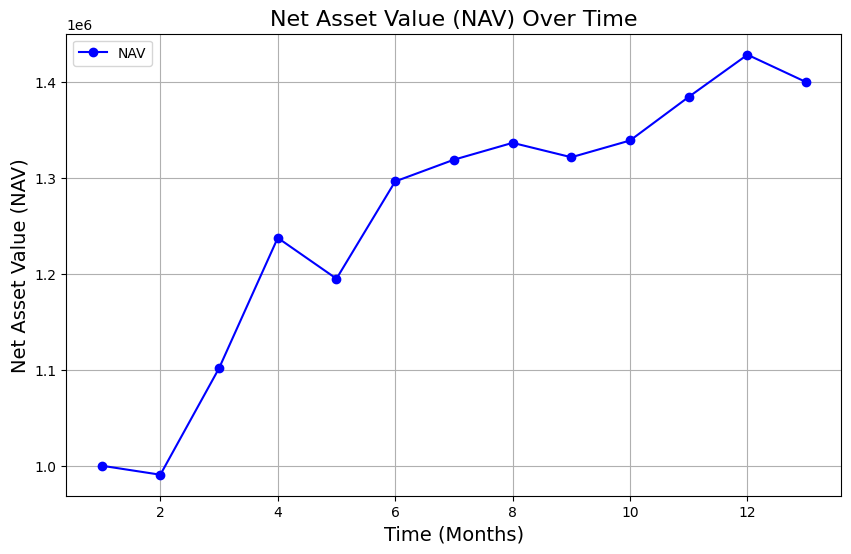

In [55]:
NAV = V.records.level

months = np.arange(1, len(NAV) + 1)  # Time in months (1, 2, 3, ..., 12)

# Create a pandas DataFrame for easier handling
data = pd.DataFrame({'Month': months, 'NAV': NAV})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Month'], data['NAV'], marker='o', linestyle='-', color='b', label='NAV')

# Add labels and title
plt.title('Net Asset Value (NAV) Over Time', fontsize=16)
plt.xlabel('Time (Months)', fontsize=14)
plt.ylabel('Net Asset Value (NAV)', fontsize=14)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

The image above shows the NAV of the fund from months 1 to 13, where 1 is December of 2023 where the fund was 'initialized'. The NAV drops in month 2 (January) as it takes on positions. The drop is represents the bid/ask spread where taking any position at the bid would instantly put you in the red as the bid/ask spread is positive. The above chart shows how the price/NAV chart of the fund would look like for the set of trades that represents the lowest possible win-loss ratio

In [54]:
df = x.records
# Step 1: Filter out rows where level is 0 (inactive positions)
active_positions_df = df[df['level'] > 0]

# Step 2: Group by time and count the number of unique stocks
active_positions_count = active_positions_df.groupby('time')['stocks'].nunique().reset_index()
active_positions_count.columns = ['time', 'active_positions']

# Print the result
print("Number of active positions at each time period:")
print(active_positions_count)


Number of active positions at each time period:
   time  active_positions
0     0                 0
1     1                38
2     2                43
3     3                61
4     4                69
5     5                82
6     6                88
7     7                82
8     8                74
9     9                78
10   10                86
11   11                88
12   12               175


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_2360\733521618.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  active_positions_count = active_positions_df.groupby('time')['stocks'].nunique().reset_index()
